# Exercise instructions
1.  You must answer the questions at the beginning of each paragraph  
2.  You must complete the code between #...#
3.  You must explain in comments the lines of code that you produce
4.  You can help and ask for help from others but you must indicate the person who helped you

# Références
https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/utils.py



In [342]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [343]:
import os
project_path = "/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/"
data_set_path = "/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Dataset/"
TRAIN_IMG_DIR = os.path.join(data_set_path,"train_frames/train")
TRAIN_MASK_DIR = os.path.join(data_set_path,"train_masks/train")
VAL_IMG_DIR = os.path.join(data_set_path,"val_frames/val")
VAL_MASK_DIR = os.path.join(data_set_path,"val_masks/val")
CHECKPOINT_PATH = os.path.join(project_path,"Save/my_checkpoint.pth.tar")
PLOT_PATH = os.path.join(project_path,"Save/Accuracy")
PLOT_VAL_PATH = os.path.join(project_path,"Save/validation")

# Dataset
https://research.aimultiple.com/datasets-for-ml/

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [344]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pdb

## Dataset Class
Questions:
1. Explain what the get_item function is for and how it is called in training mechanism?
**Answer:**
\
The __getitem__ function in a PyTorch dataset class retrieves and preprocesses individual data items, and is automatically called by the DataLoader during training to provide batches of data for the model.
2. why do we have to divide mask by 255?

**Answer:**
\
 By dividing each pixel value in the mask by 255, you convert the range from 0-255 to 0-1.


In [345]:
class HorizonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

# Create a HorizonDataset class that derives from the pytorch Dataset class and complete the __getitem__(self, index) method.
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        mask  = Image.open(mask_path).convert("L")
        mask  = np.array(mask,dtype=np.float32)
        mask  = mask/255.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask



## Loader definition
Questions:
1. Explain what the data loader is for?
**Answer:**
\
The get_loaders function in the provided code creates and returns PyTorch DataLoader objects for both training and validation datasets, enabling efficient, batched, and optionally shuffled data loading for model training and evaluation.

In [346]:
# The data loader allows you to iterate over the dataset.
# Each iteration below returns a batch of train_features and train_labels

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HorizonDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

# Warning to shuffle (true or false ??? explain why in commentary)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = HorizonDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )
# Warning to shuffle (true or false ??? explain why in commentary)
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

# Model definition
https://www.pinecone.io/learn/batch-layer-normalization/

https://medium.com/data-science-365/batch-normalization-explained-in-plain-english-3436014f9e52

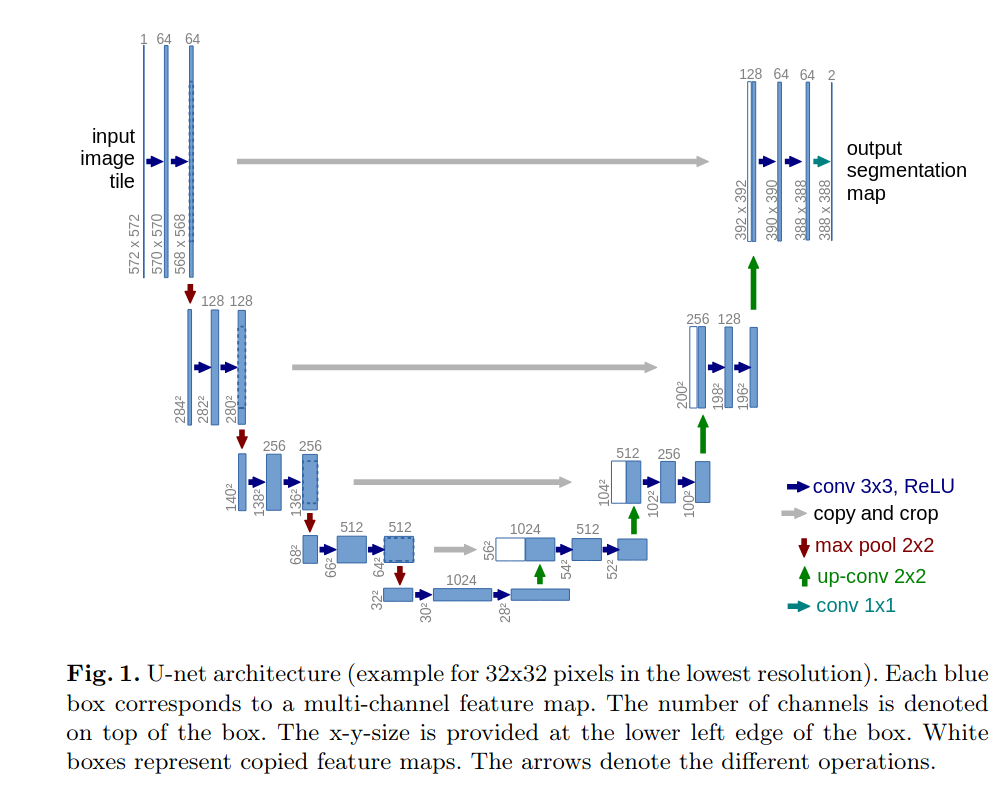

In [347]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# explain the line of code below
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Double convolution
Questions:
1. From the network diagram above, code an elementary brick composed of a convolution layer.Do the same but limiting to a single convolution layer.

In [348]:
 #Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d ->  ReLU#
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
             #....................#


    def forward(self, x):
        return self.conv(x)

In [349]:
# The same but with only one sequence
class SimpleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
        super(SimpleConv, self).__init__()
        self.conv = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
             #....................#


  def forward(self, x):
        return self.conv(x)
  #....................#


## Model
https://arxiv.org/pdf/1505.04597.pdf

Questions :
1.  Complete the model code from the publication schema.
2.  Complete the descending part then the rising part of the Unet.
3.  For the rising part, use ConvTranspose2d
4.  Use the DoubleConv function first and then the SimpleConv, make comments

In [350]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
        ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            #self.downs.append(SimpleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
            #self.ups.append(SimpleConv(feature*2, feature))

            # The bottom layer
        #self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.bottleneck = SimpleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)



# Evaluation metric
Evaluation metrics are quantitative measures used to assess the performance and effectiveness of a statistical or machine learning model. These metrics provide insights into how well the model is performing and help in comparing different models or algorithms.

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

Q: Write a function which calculates the accuracy which is the number of pixels OK compared to the total number of pixels and which calculates the dice score. This function will return the dice score as a validation metric.
Comment on the use of model.eval() and model.train()

In [351]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval() # This sets the model to evaluation mode, deactivating layers such as dropout and bypassing mini-batch normalization.

    with torch.no_grad():
        for x, y in loader:

          x ,y = x.to(device), y.to(device)
          y_pred = torch.sigmoid(model(x))
          y_pred = (y_pred > 0.5).float()
          intersection = torch.sum(y_pred * y)        # Get the pixels common in prediction and label
          union = torch.sum(y_pred) + torch.sum(y)    # Get the sum of pixels in prediction and label
          dice = 2 * intersection/ (union + 1e-8)     # Calculate the dice coefficient

          dice_score += dice.item()
          num_correct += (y_pred == y).sum().item()    # Get the pixels correctly classified
          num_pixels += torch.numel(y)        # Get the total number of pixels

            #...""


          #The Dice coefficient, utilized to gauge the pixel-level similarity between a predicted segmentation and its actual ground truth,
          #is calculated as twice the area of overlap divided by the combined pixel count of both images.


    #...#
    val_accuracy = dice_score/len(loader)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {val_accuracy}")
    model.train()

    return val_accuracy


# Training
https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/

In [353]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
IMAGE_HEIGHT = 128 #128 # 1280 originally
IMAGE_WIDTH = 256  #256 # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False


## Hyper parameters

In [354]:
class HyperParameters:
    def __init__(self, learning_rate, batch_size,epoch_numbers):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_numbers = epoch_numbers

## Train function
Qestions
1. Write a function that calculates the loss on validation data.
2. Write a function that saves an image and the network prediction for each epoch to visualize the learning progress.
3. Write a function that calculates the loss on training data.
4. Make a comment on optimizer.zero_grad(), scaler.scale(loss).backward(),scaler.step(optimizer), scaler.update()


In [361]:
def check_val_loss(loader, model,loss_fn, device="cuda"):
    totalValLoss = 0.0
    model.eval()

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device),targets.float().unsqueeze(1).to(device=DEVICE)         #targets.to(device)
            outputs = model(data)
            #print(outputs.shape)
            #print(targets.shape)
            loss = loss_fn(outputs, targets)
            totalValLoss += loss.item()
            #...#

    #...#
    val_loss = totalValLoss/len(loader)
    print(f"Val loss: {val_loss}")
    model.train()

    return val_loss

def save_eval(loader, model,epoch,file_path="eval_image", device="cuda"):

    model.eval()

    with torch.no_grad():
            val_images, val_masks = next(iter(loader))
            val_images = val_images.to(device=DEVICE)
            filename = file_path +"_" +str(epoch)
            predictions = model(val_images)      # Get the logits
            preds = torch.sigmoid(predictions)   # use sigmoid to get the map

            # Extract only the (H,W)
            image = val_images[0][0].cpu().numpy()
            mask = val_masks[0].cpu().numpy()
            pred_mask = preds[0,0,:,:].cpu().numpy()

            fig, axs = plt.subplots(1,3, figsize=(10,3))
            axs[0].imshow(image, cmap='gray')
            axs[0].set_title('Image')
            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title('Base Mask')
            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title('Predicted Mask')

            fig.suptitle(f'Image, Base Mask, and Predicted Mask for epoch:{epoch}')
            # Save the figure
            plt.savefig(f"{filename}_sample.png")
            plt.close()
            # We take a single image and its maks from the dataloader, use the model to output predictions, use the sigmoid on the logits and then plot the original image, ground truth and predicted mask #


        #...#

    model.train()

'''
When the model is configured into training mode via model.train(), it is being primed for the training phase.
This activates certain training-specific behaviors such as dropout and batch normalization,
which introduce randomness and foster generalization in the training process.
In this mode, the model yields a list comprising three elements that pertain to the training procedure.

Conversely, setting the model into evaluation mode with model.eval()
prepares it for inference or evaluation. This mode deactivates the randomness elements
like dropout and batch normalization to ensure consistent outputs for identical inputs.
During this stage, the model produces a more concise,
two-element tuple, which is typically the processed output ready for final use.

The variation in the number of elements between these modes reflects the differing informational needs at each stage of the model's lifecycle.
In training mode (model.train()), more granular, layer-specific information is often required for processes such as back-propagation and gradient adjustments.
In contrast, evaluation mode (model.eval()) generally necessitates only the model's final output.

The second element of the tuple in evaluation mode and the elements in the training mode list,
while analogous in representing aspects like activation outputs, differ in their specific values due to the distinct behaviors enacted in each mode.
  '''


"\nWhen the model is configured into training mode via model.train(), it is being primed for the training phase.\nThis activates certain training-specific behaviors such as dropout and batch normalization,\nwhich introduce randomness and foster generalization in the training process.\nIn this mode, the model yields a list comprising three elements that pertain to the training procedure.\n\nConversely, setting the model into evaluation mode with model.eval()\nprepares it for inference or evaluation. This mode deactivates the randomness elements\nlike dropout and batch normalization to ensure consistent outputs for identical inputs.\nDuring this stage, the model produces a more concise,\ntwo-element tuple, which is typically the processed output ready for final use.\n\nThe variation in the number of elements between these modes reflects the differing informational needs at each stage of the model's lifecycle.\nIn training mode (model.train()), more granular, layer-specific information is

In [356]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    totalTrainLoss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE) #...#
        #targets = targets.float().unsqueeze(1).to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE) #...#
        #print(f'data shape is :',data.shape)    # Should be [batch_size, channels, height, width]
        #print(f'targets shape is :',targets.shape)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data) #...#
            #print(f'shape of predictions{predictions.shape} & shape of targets{targets.shape}')
            loss =  loss_fn(predictions,targets)#...#
            totalTrainLoss += loss.item()

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    #...#
    train_loss = totalTrainLoss/len(loader)
    print(f"Tain loss: {train_loss}")

    return train_loss


## Training script
Questions:
1. Write a function wich plot and save train_loss, val_loss and val_acc
2. Write a function which save ckeckpoint file
3. Make a comment on:
A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            )
4.  Why are transformations missing for validation data?
5.  Why  nn.BCEWithLogitsLoss() is used instead of classical BCE?
6.  Make a comment on: torch.cuda.amp.GradScaler()
7.  What is Adam? What’s the main difference between Adam and SGD?
**Answer:** *Adam is an optimization algorithm used in training neural networks, known for its efficiency in handling sparse gradients and adaptive learning rates. The main difference between Adam and Stochastic Gradient Descent (SGD) is that Adam adjusts the learning rate for each parameter based on the computation of adaptive first and second moment estimates of the gradients, while SGD uses a constant learning rate for all weight updates. Adam generally converges faster than SGD but requires less manual tuning.*

In [357]:
import matplotlib.pyplot as plt


class Results:
      def __init__(self,file_path="results"):
        self.result_dict = {
	             "train_loss": [],
	              "val_loss": [],
	              "val_acc": []
                }
        self.path = file_path

      def add_result(self, train_loss, val_loss,val_acc):
        self.result_dict["train_loss"].append(train_loss)
        self.result_dict["val_loss"].append(val_loss)
        self.result_dict["val_acc"].append(val_acc)

      def plotAndSave(self, n_epoch):
        filename = self.path + "_" + str(n_epoch)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        #print(self.result_dict["train_loss"])


        plt.plot(np.arange(n_epoch+1), self.result_dict["train_loss"], label='Train Loss')
        plt.title('Train Loss')
        plt.subplot(1, 3, 2)
        print(self.result_dict["val_loss"])
        plt.plot(np.arange(n_epoch+1), self.result_dict["val_loss"], label='Validation Loss')
        plt.title('Validation Loss')
        plt.subplot(1, 3, 3)
        plt.plot(np.arange(n_epoch+1),self.result_dict["val_acc"], label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()
        plt.savefig(f'{filename}.png')
        plt.show()


        #..#



In [358]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint: ")
    print(filename)
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def run_training(hyper_parameters):

    results = Results(file_path = PLOT_PATH)
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), # adjust image size to a fixed size
            A.Rotate(limit=35, p=1.0), # randomly rotate image
            A.HorizontalFlip(p=0.5), # randomly flip images horizontally
            A.VerticalFlip(p=0.1), # randomly flip images vertically
            A.Normalize(
               mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ), # normalize image with mean and standard deviation
            ToTensorV2(), # convert image to tensor
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH), # adjust image size to a fixed size
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ), # normalize image with mean and standard deviation
            ToTensorV2(), # convert image to tensor
        ],
    )

    #model = UNET(in_channels=3, out_channels=1 , features=[64, 128, 256, 512]).to(DEVICE)
    model = UNET().to(DEVICE)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters.learning_rate)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        hyper_parameters.batch_size,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    check_accuracy(val_loader, model, device=DEVICE)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(hyper_parameters.epoch_numbers):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=CHECKPOINT_PATH)
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device=DEVICE)

        val_loss = check_val_loss(val_loader, model, loss_fn)
        # check accuracy
        val_accuracy = check_accuracy(val_loader, model, device="cuda") #DEVICE

        results.add_result(train_loss, val_loss, val_accuracy)

        results.plotAndSave(epoch)
        save_eval(val_loader, model, epoch, PLOT_VAL_PATH, device="cuda")  #DEVICE

    return model


# Run Training

Got 234040833/117800960 with acc 198.67
Dice score: 0.38974480292820957


100%|██████████| 1798/1798 [02:48<00:00, 10.69it/s, loss=0.0144]


Tain loss: 0.06233246944579519
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.016662820047585996
Got 447483606/117800960 with acc 379.86
Dice score: 3.8102114593094263
[0.016662820047585996]


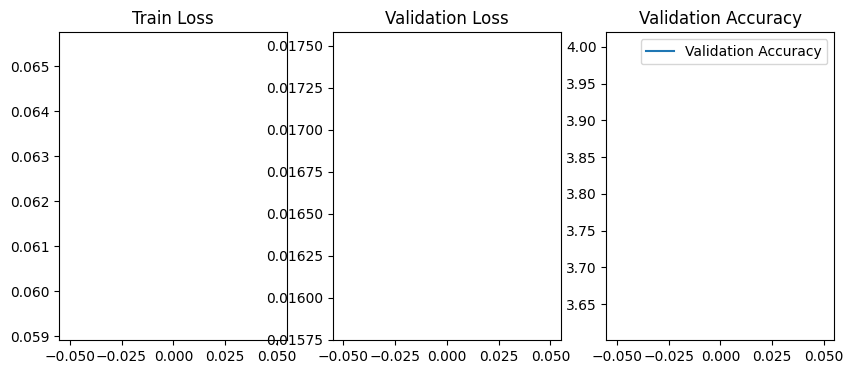

100%|██████████| 1798/1798 [02:52<00:00, 10.43it/s, loss=0.0104]


Tain loss: 0.02103590996634501
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.011650774799633327
Got 447766715/117800960 with acc 380.10
Dice score: 3.812516944426981
[0.016662820047585996, 0.011650774799633327]


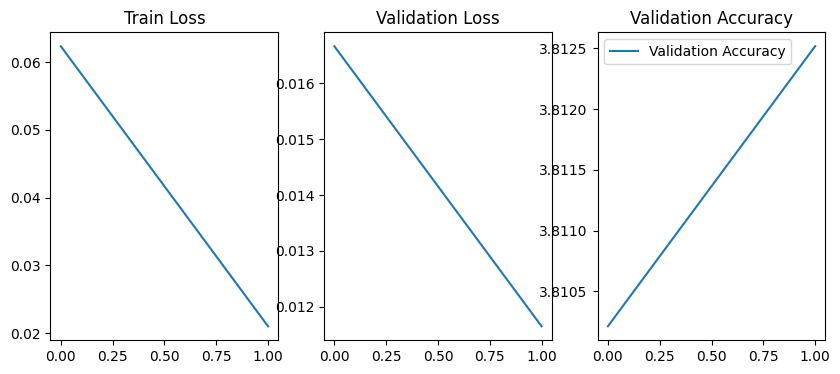

100%|██████████| 1798/1798 [02:53<00:00, 10.37it/s, loss=0.014]


Tain loss: 0.016179746845105168
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.00926676687491318
Got 447821914/117800960 with acc 380.15
Dice score: 3.8132040460860237
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318]


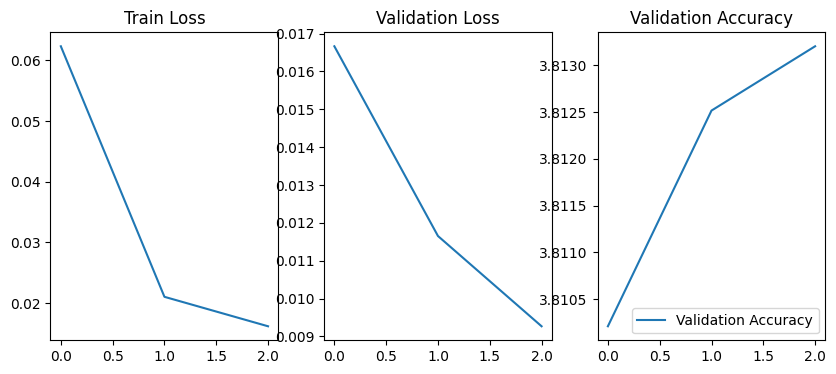

100%|██████████| 1798/1798 [02:45<00:00, 10.86it/s, loss=0.0218]


Tain loss: 0.01407340537338156
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.01463512338524906
Got 447524252/117800960 with acc 379.90
Dice score: 3.810574000351156
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906]


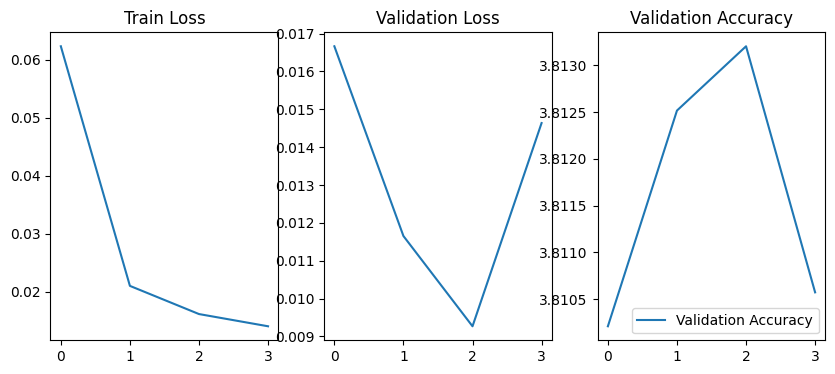

100%|██████████| 1798/1798 [03:03<00:00,  9.80it/s, loss=0.0049]


Tain loss: 0.01205583995009241
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008690621032306015
Got 447852931/117800960 with acc 380.18
Dice score: 3.813380822456453
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015]


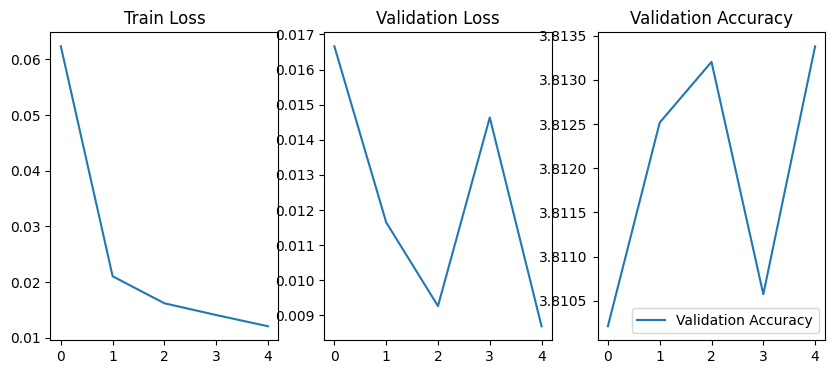

100%|██████████| 1798/1798 [02:51<00:00, 10.46it/s, loss=0.00873]


Tain loss: 0.013288650868379732
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.01129520285832649
Got 447706502/117800960 with acc 380.05
Dice score: 3.8120231596593466
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015, 0.01129520285832649]


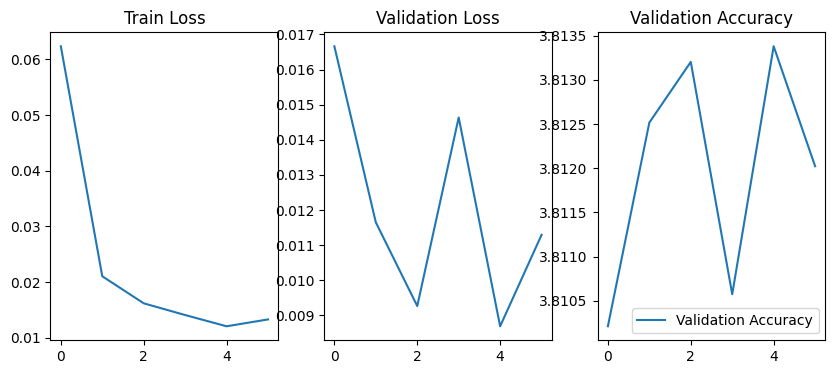

100%|██████████| 1798/1798 [02:44<00:00, 10.92it/s, loss=0.00666]


Tain loss: 0.010265662908518854
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.006648131653338099
Got 448126425/117800960 with acc 380.41
Dice score: 3.815770329039407
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015, 0.01129520285832649, 0.006648131653338099]


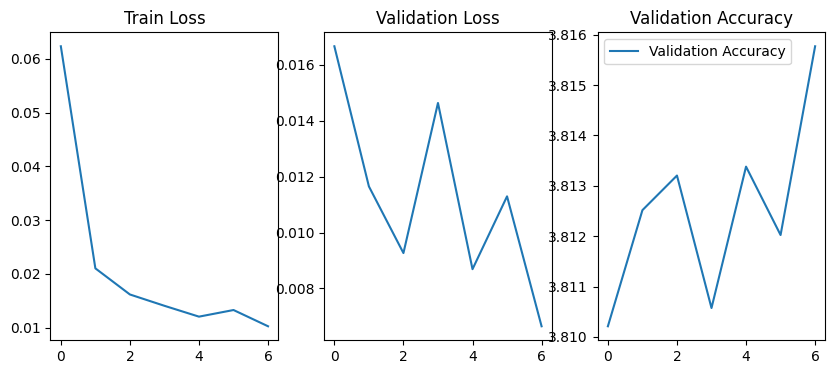

100%|██████████| 1798/1798 [02:43<00:00, 11.00it/s, loss=0.00656]


Tain loss: 0.010090190227955655
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.00796067570473427
Got 447971591/117800960 with acc 380.28
Dice score: 3.8142771880008755
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015, 0.01129520285832649, 0.006648131653338099, 0.00796067570473427]


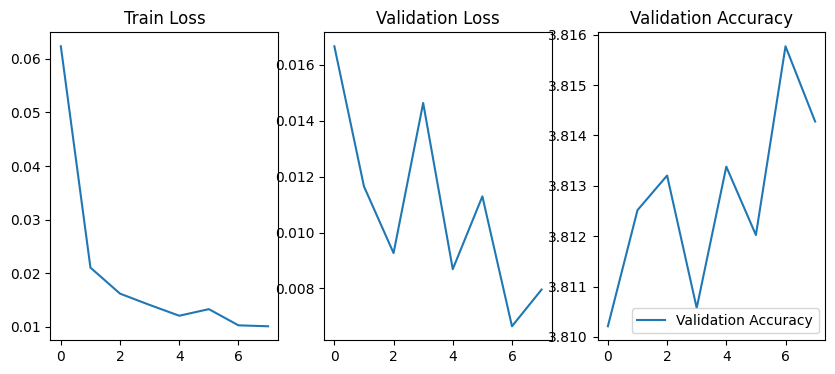

100%|██████████| 1798/1798 [02:50<00:00, 10.56it/s, loss=0.00576]


Tain loss: 0.009818733338700677
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.008437611465031556
Got 447933330/117800960 with acc 380.25
Dice score: 3.813889705299403
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015, 0.01129520285832649, 0.006648131653338099, 0.00796067570473427, 0.008437611465031556]


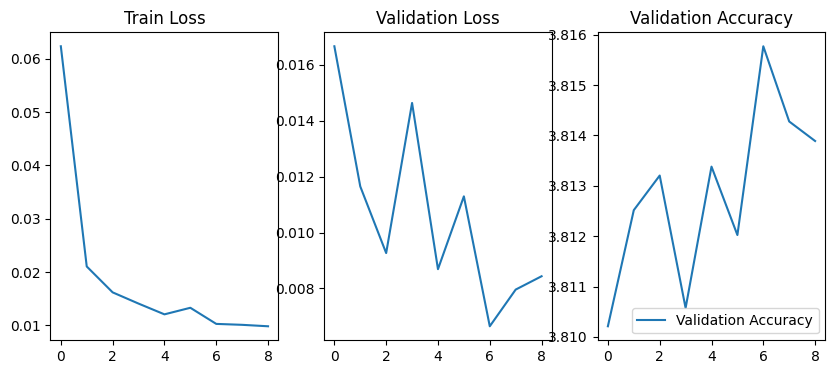

100%|██████████| 1798/1798 [02:49<00:00, 10.61it/s, loss=0.00367]


Tain loss: 0.009304572756633211
=> Saving checkpoint: 
/content/drive/MyDrive/Colab_Notebooks/Deep Learning Arnaud Pietrosemoli/HorizonSegmentation/Save/my_checkpoint.pth.tar
Val loss: 0.007717666593152363
Got 448013475/117800960 with acc 380.31
Dice score: 3.8147179377622678
[0.016662820047585996, 0.011650774799633327, 0.00926676687491318, 0.01463512338524906, 0.008690621032306015, 0.01129520285832649, 0.006648131653338099, 0.00796067570473427, 0.008437611465031556, 0.007717666593152363]


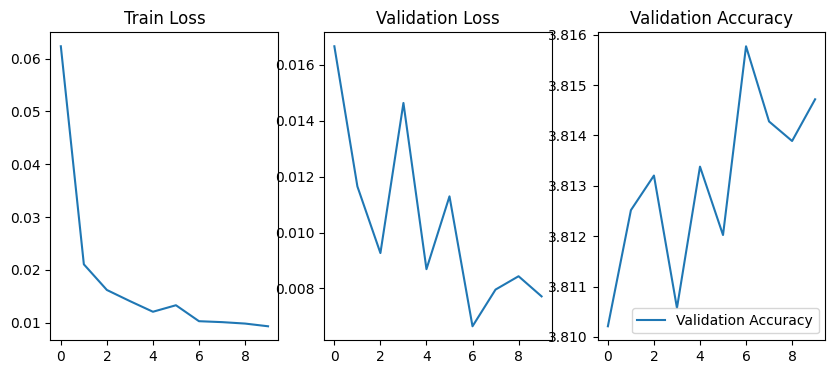

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [359]:
hyper_parameters = HyperParameters(learning_rate = 1e-4, batch_size = 4, epoch_numbers = 10)
run_training(hyper_parameters)


#Should be [batch_size, channels, height, width]

# Evaluation

=> Loading checkpoint
y size : torch.Size([4, 1, 128, 256])
preds size: torch.Size([4, 1, 128, 256])


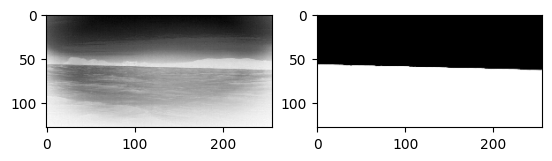

In [360]:
import albumentations as A
model = UNET().to(device = "cuda")
load_checkpoint(torch.load(CHECKPOINT_PATH), model)

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_ds = HorizonDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transforms
    )

val_loader = DataLoader(
        val_ds,
        batch_size= 4,
        num_workers=2,
        pin_memory=True,
        shuffle=False
)

val_images, val_masks = next(iter(val_loader))

data = val_images.to("cuda")
y = model(data)

preds = torch.sigmoid(y)
print(f"y size : {y.size()}")
print(f"preds size: {preds.size()}")

preds = preds.cpu().detach().numpy()



f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(val_images[1][0], cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(preds[1][0], cmap="gray")
plt.show(block=True)

